In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.nuscenes import RadarPointCloud
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix

import operator
import time

import cv2
import numpy as np
import open3d as o3d
from mayavi import mlab
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from pyquaternion import Quaternion

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
nusc = NuScenes(version='v1.0-mini', 
                dataroot='/home/charles/myDataSet/nuScenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.314 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


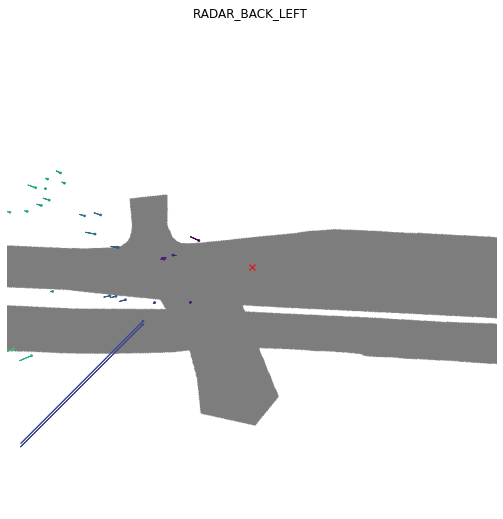

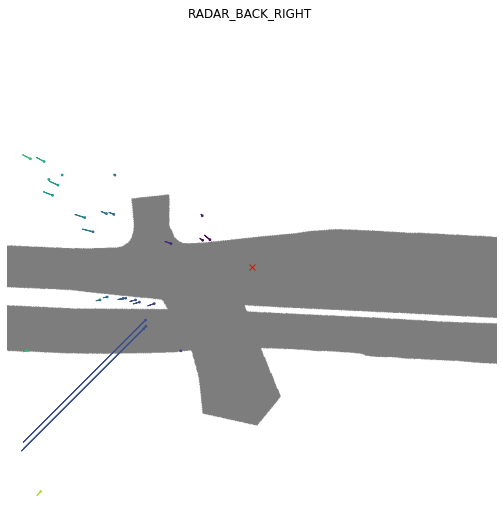

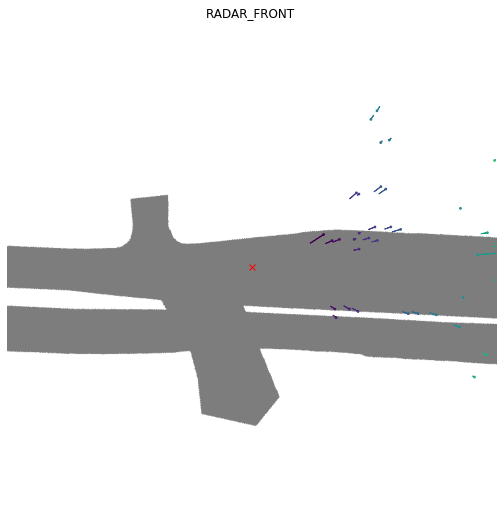

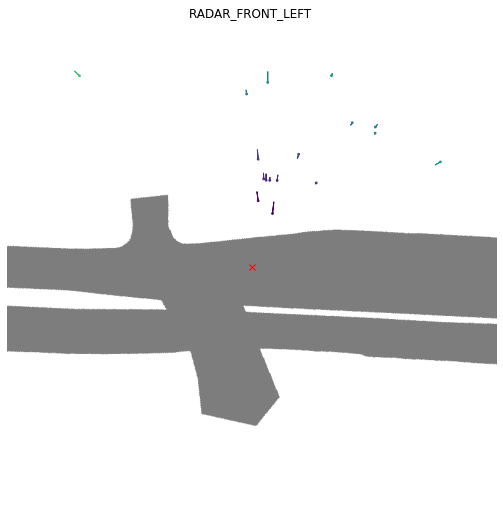

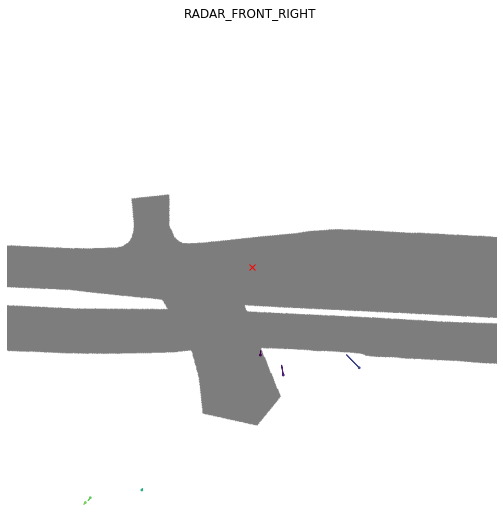

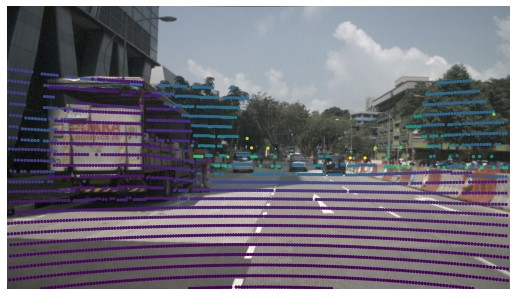

In [3]:
scene = nusc.scene[0] 

# 获取该场景的first token
cur_sample_info = nusc.get('sample', scene['first_sample_token'])
# print(cur_sample_info)
sensor_data_token = nusc.get('sample_data', cur_sample_info['data']['RADAR_FRONT'])

# print(sensor_data_token)
path_ = nusc.get_sample_data_path(cur_sample_info['data']['RADAR_FRONT'])
# print(path_)
radar_list = ['RADAR_BACK_LEFT','RADAR_BACK_RIGHT','RADAR_FRONT','RADAR_FRONT_LEFT','RADAR_FRONT_RIGHT']
for radar_part in radar_list:
    nusc.render_sample_data(cur_sample_info['data'][radar_part], with_anns = False) #只显示radar点云

nusc.render_pointcloud_in_image(cur_sample_info['token'],pointsensor_channel='LIDAR_TOP')  #将点云投到图像上

In [4]:
def get_radar_point(nusc, 
                    sample_data_token: str,
                    nsweeps=1, use_flat_vehicle_coordinates=True, 
                    ax: Axes = None, axes_limit: float = 100,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY,
                     with_anns: bool = True):
    
    sd_record = nusc.get('sample_data', sample_data_token)
    sample_rec = nusc.get('sample', sd_record['sample_token'])
    chan = sd_record['channel']
    ref_chan = 'LIDAR_TOP'
    ref_sd_token = sample_rec['data'][ref_chan]
    ref_sd_record = nusc.get('sample_data', ref_sd_token)

    pc, times = RadarPointCloud.from_file_multisweep(nusc, sample_rec, chan, ref_chan, nsweeps=nsweeps)

    # Transform radar velocities (x is front, y is left), as these are not transformed when loading the
    # point cloud.
    radar_cs_record = nusc.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    ref_cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
    velocities = pc.points[8:10, :]  # Compensated velocity
    velocities = np.vstack((velocities, np.zeros(pc.points.shape[1])))
    velocities = np.dot(Quaternion(radar_cs_record['rotation']).rotation_matrix, velocities)
    velocities = np.dot(Quaternion(ref_cs_record['rotation']).rotation_matrix.T, velocities)
    velocities[2, :] = np.zeros(pc.points.shape[1])

    # By default we render the sample_data top down in the sensor frame.
    # This is slightly inaccurate when rendering the map as the sensor frame may not be perfectly upright.
    # Using use_flat_vehicle_coordinates we can render the map in the ego frame instead.
    if use_flat_vehicle_coordinates:
        # Retrieve transformation matrices for reference point cloud.
        cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
        pose_record = nusc.get('ego_pose', ref_sd_record['ego_pose_token'])
        ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                        rotation=Quaternion(cs_record["rotation"]))

        # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
        ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
        rotation_vehicle_flat_from_vehicle = np.dot(
            Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
            Quaternion(pose_record['rotation']).inverse.rotation_matrix)
        vehicle_flat_from_vehicle = np.eye(4)
        vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
        viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)
    else:
        viewpoint = np.eye(4)
    
    points = view_points(pc.points[:3, :], viewpoint, normalize=False)
    dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
    colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
            
    
    point_scale = 3.0
    scatter = ax.scatter(points[0, :], points[1, :], c=colors, s=point_scale)
                        
    points_vel = view_points(pc.points[:3, :] + velocities, viewpoint, normalize=False)
    deltas_vel = points_vel - points
    deltas_vel = 6 * deltas_vel  # Arbitrary scaling
    max_delta = 20
    deltas_vel = np.clip(deltas_vel, -max_delta, max_delta)  # Arbitrary clipping
    colors_rgba = scatter.to_rgba(colors)
    for i in range(points.shape[1]):
        ax.arrow(points[0, i], points[1, i], deltas_vel[0, i], deltas_vel[1, i], color=colors_rgba[i])

    # Show ego vehicle.
    ax.plot(0, 0, 'x', color='red')
    
    # Get boxes in lidar frame.
    _, boxes, _ = nusc.get_sample_data(ref_sd_token, box_vis_level=box_vis_level,
                                            use_flat_vehicle_coordinates=use_flat_vehicle_coordinates)

    # Show boxes.
    if with_anns:
        for box in boxes:
            c = np.array(nusc.explorer.get_color(box.name)) / 255.0
            box.render(ax, view=np.eye(4), colors=(c, c, c))

    # Limit visible range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
            
    return pc, velocities

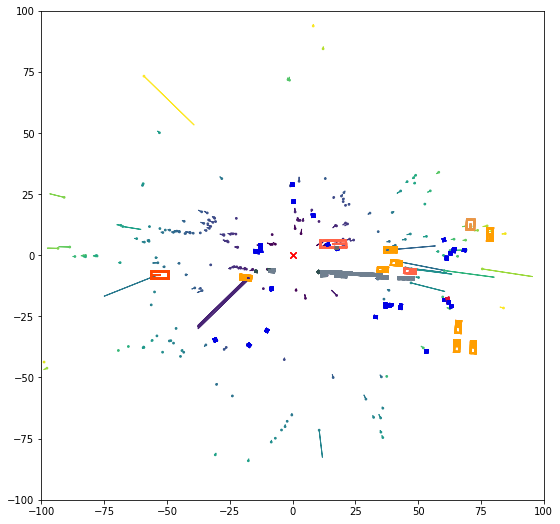

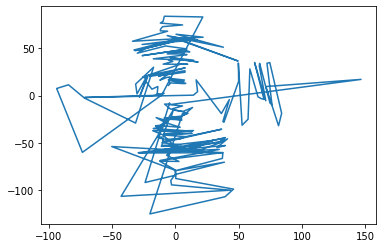

In [10]:
scene = nusc.scene[0] 
_, ax = plt.subplots(1, 1, figsize=(9, 9))
radar_list = ['RADAR_FRONT','RADAR_FRONT_LEFT','RADAR_FRONT_RIGHT','RADAR_BACK_LEFT','RADAR_BACK_RIGHT',]
for sub_ in radar_list:

    pc, velocities = get_radar_point(nusc, cur_sample_info['data'][sub_], ax=ax)
    if sub_ == 'RADAR_FRONT':
        all_point = pc.points
    else:
        all_point = np.hstack((all_point, pc.points))
plt.figure()
plt.plot(all_point[0,:],all_point[1,:])


In [15]:
a = all_point[:3, :].T
a.shape

(241, 3)